In [ ]:
!pip install --quiet neo4j langchain-community langchain-core langchain-openai langgraph

In [1]:
import os
from operator import add

import re
import ast
import getpass
from typing import List, Dict, Literal, Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector

from pydantic import BaseModel, Field

# Implementing GraphReader with Neo4j and LangGraph

Large Language Models (LLMs) are great at traditional NLP tasks like summarization and sentiment analysis but the stronger models also demonstrate promising reasoning abilities. LLM reasoning is often understood as the ability to tackle complex problems by formulating a plan, executing it, and assessing progress at each step. Based on this evaluation, they can adapt by revising the plan or taking alternative actions. The rise of agents is becoming an increasingly compelling approach to answering complex questions in RAG applications.

In this blog post, we’ll explore the implementation of the GraphReader agent. This agent is designed to retrieve information from a structured knowledge graph that follows a predefined schema. Unlike the typical graphs you might see in presentations, this one is closer to a document or lexical graph, containing documents, their chunks, and relevant metadata in the form of atomic facts.

![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*aws90bkQ8PPNYFFIbXdMpA.png)

The image above illustrates a knowledge graph, beginning at the top with a document node labeled Joan of Arc. This document is broken down into text chunks, represented by numbered circular nodes (0, 1, 2, 3), which are connected sequentially through NEXT relationships, indicating the order in which the chunks appear in the document. Below the text chunks, the graph further breaks down into atomic facts, where specific statements about the content are represented. Finally, at the bottom level of the graph, we see the key elements, represented as circular nodes with topics like historical icons, Dane, French nation, and France. These elements act as metadata, linking the facts to the broader themes and concepts relevant to the document.

Once we have constructed the knowledge graph, we will follow the implementation provided in the GraphReader paper.

![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*PokbiJwPnZ6Fndfo9tPwbg.png)

The agent exploration process involves initializing the agent with a rational plan and selecting initial nodes to start the search in a graph. The agent explores these nodes by first gathering atomic facts, then reading relevant text chunks, and updating its notebook. The agent can decide to explore more chunks, neighboring nodes, or terminate based on gathered information. When the agent decided to terminate, the answer reasoning step is executed to generate the final answer.

In this blog post, we will implement the GraphReader paper using Neo4j as the storage layer and LangChain in combination with LangGraph to define the agent and its flow.

**Make sure to run the graphreader import notebook first!!!**

In [3]:
os.environ["NEO4J_URI"] = "neo4j+s://089bfb9e.databases.neo4j.io"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "jsSYcLP-a_JvuHYh7xKf5890FOrn1El5BvlXUQGr8hM"

neo4j_graph = Neo4jGraph(refresh_schema=False)

In [5]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
#"gpt-4-0125-preview"
model = ChatOpenAI(model="gpt-4-turbo", temperature=0.2)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

OpenAI API Key: ········


# GraphReader Agent
We’re ready to implement GraphReader, a graph-based agent system. The agent starts with a couple of predefined steps, followed by the steps in which it can traverse the graph autonomously, meaning the agent decides the following steps and how to traverse the graph.

![image](https://miro.medium.com/v2/resize:fit:740/format:webp/1*brUZD1mkh9tDg8AwMEmxTw.png)

The process begins with a rational planning stage, after which the agent makes an initial selection of nodes (key elements) to work with. Next, the agent checks atomic facts linked to the selected key elements. Since all these steps are predefined, they are visualized with a full line.

Depending on the outcome of the atomic fact check, the flow proceeds to either read relevant text chunks or explore the neighbors of the initial key elements in search of more relevant information. Here, the next step is conditional and based on the results of an LLM and is, therefore, visualized with a dotted line.

In the chunk check stage, the LLM reads and evaluates whether the information gathered from the current text chunk is sufficient. Based on this evaluation, the LLM has a few options. It can decide to read additional text chunks if the information seems incomplete or unclear. Alternatively, the LLM may choose to explore neighboring key elements, looking for more context or related information that the initial selection might not have captured. If, however, the LLM determines that enough relevant information has been gathered, it will proceed directly to the answer reasoning step. At this point, the LLM generates the final answer based on the collected information.

Throughout this process, the agent dynamically navigates the flow based on the outcomes of the conditional checks, making decisions on whether to repeat steps or continue forward depending on the specific situation. This provides flexibility in handling different inputs while maintaining a structured progression through the steps.

Now, we’ll go over the steps and implement them using LangGraph abstraction. You can learn more about LangGraph through LangChain’s academy course.

## LangGraph state
To build a LangGraph implementation, we start by defining a state passed along the steps in the flow.

In [7]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str
    analysis: str
    previous_actions: List[str]

class OverallState(TypedDict):
    question: str
    rational_plan: str
    notebook: str
    previous_actions: Annotated[List[str], add]
    check_atomic_facts_queue: List[str]
    check_chunks_queue: List[str]
    neighbor_check_queue: List[str]
    chosen_action: str

In [9]:
def parse_function(input_str):
    # Regular expression to capture the function name and arguments
    pattern = r'(\w+)(?:\((.*)\))?'
    
    match = re.match(pattern, input_str)
    if match:
        function_name = match.group(1)  # Extract the function name
        raw_arguments = match.group(2)  # Extract the arguments as a string        
        # If there are arguments, attempt to parse them
        arguments = []
        if raw_arguments:
            try:
                # Use ast.literal_eval to safely evaluate and convert the arguments
                parsed_args = ast.literal_eval(f'({raw_arguments})')  # Wrap in tuple parentheses
                # Ensure it's always treated as a tuple even with a single argument
                arguments = list(parsed_args) if isinstance(parsed_args, tuple) else [parsed_args]
            except (ValueError, SyntaxError):
                # In case of failure to parse, return the raw argument string
                arguments = [raw_arguments.strip()]
        

        return {
            'function_name': function_name,
            'arguments': arguments
        }
    else:
        return None

For more advanced use cases, multiple separate states can be used. In our implementation, we have separate input and output states, which define the input and output of the LangGraph, and a separate overall state, which is passed between steps.

By default, the state is overwritten when returned from a node. However, you can define other operations. For example, with the previous_actions we define that the state is appended or added instead of overwritten.

The agent begins by maintaining a notebook to record supporting facts, which are eventually used to derive the final answer. Other states will be explained as we go along.

Let’s move on to defining the nodes in the LangGraph.

## Rational plan
In the rational plan step, the agent breaks the question into smaller steps, identifies the key information required, and creates a logical plan. The logical plan allows the agent to handle complex multi-step questions.

While the code is unavailable, all the prompts are in the appendix, so we can easily copy them.
The authors don’t explicitly state whether the prompt is provided in the system or user message. For the most part, I have decided to put the instructions as a system message.

The following code shows how to construct a chain using the above rational plan as the system message.

In [11]:
rational_plan_system = """As an intelligent assistant, your primary objective is to answer the question by gathering
supporting facts from a given article. To facilitate this objective, the first step is to make
a rational plan based on the question. This plan should outline the step-by-step process to
resolve the question and specify the key information required to formulate a comprehensive answer.
Example:
#####
User: Who had a longer tennis career, Danny or Alice?
Assistant: In order to answer this question, we first need to find the length of Danny’s
and Alice’s tennis careers, such as the start and retirement of their careers, and then compare the
two.
#####
Please strictly follow the above format. Let’s begin."""

rational_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            rational_plan_system,
        ),
        (
            "human",
            (
                "{question}"
            ),
        ),
    ]
)

rational_chain = rational_prompt | model | StrOutputParser()

def rational_plan_node(state: InputState) -> OverallState:
    rational_plan = rational_chain.invoke({"question": state.get("question")})
    print("-" * 20)
    print(f"Step: rational_plan")
    print(f"Rational plan: {rational_plan}")
    return {
        "rational_plan": rational_plan,
        "previous_actions": ["rational_plan"],
    }

The function starts by invoking the LLM chain, which produces the rational plan. We do a little printing for debugging and then update the state as the function’s output. I like the simplicity of this approach.

## Initial node selection
In the next step, we select the initial nodes based on the question and rational plan. The prompt starts by giving the LLM some context about the overall agent system, followed by the task instructions. The idea is to have the LLM select the top 10 most relevant nodes and score them. The authors simply put all the key elements from the database in the prompt for an LLM to select from. However, I think that approach doesn’t really scale. Therefore, we will create and use a vector index to retrieve a list of input nodes for the prompt.

In [13]:
neo4j_vector = Neo4jVector.from_existing_graph(
    embedding=embeddings,
    index_name="keyelements",
    node_label="KeyElement",
    text_node_properties=["id"],
    embedding_node_property="embedding",
    retrieval_query="RETURN node.id AS text, score, {} AS metadata"
)

def get_potential_nodes(question: str) -> List[str]:
    data = neo4j_vector.similarity_search(question, k=50)
    return [el.page_content for el in data]


The from_existing_graph method pulls the defined text_node_properties from the graph and calculates embeddings where they are missing. Here, we simply embed the id property of KeyElement nodes.

Now let’s define the chain. We’ll first copy the prompt.

In [15]:
initial_node_system = """
As an intelligent assistant, your primary objective is to answer questions based on information
contained within a text. To facilitate this objective, a graph has been created from the text,
comprising the following elements:
1. Text Chunks: Chunks of the original text.
2. Atomic Facts: Smallest, indivisible truths extracted from text chunks.
3. Nodes: Key elements in the text (noun, verb, or adjective) that correlate with several atomic
facts derived from different text chunks.
Your current task is to check a list of nodes, with the objective of selecting the most relevant initial nodes from the graph to efficiently answer the question. You are given the question, the
rational plan, and a list of node key elements. These initial nodes are crucial because they are the
starting point for searching for relevant information.
Requirements:
#####
1. Once you have selected a starting node, assess its relevance to the potential answer by assigning
a score between 0 and 100. A score of 100 implies a high likelihood of relevance to the answer,
whereas a score of 0 suggests minimal relevance.
2. Present each chosen starting node in a separate line, accompanied by its relevance score. Format
each line as follows: Node: [Key Element of Node], Score: [Relevance Score].
3. Please select at least 10 starting nodes, ensuring they are non-repetitive and diverse.
4. In the user’s input, each line constitutes a node. When selecting the starting node, please make
your choice from those provided, and refrain from fabricating your own. The nodes you output
must correspond exactly to the nodes given by the user, with identical wording.
Finally, I emphasize again that you need to select the starting node from the given Nodes, and
it must be consistent with the words of the node you selected. Please strictly follow the above
format. Let’s begin.
"""

initial_node_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            initial_node_system,
        ),
        (
            "human",
            (
                """Question: {question}
Plan: {rational_plan}
Nodes: {nodes}"""
            ),
        ),
    ]
)

Again, we put most of the instructions as the system message. Since we have multiple inputs, we can define them in the human message. However, we need a more structured output this time. Instead of writing a parsing function that takes in text and outputs a JSON, we can simply use the use_structured_outputmethod to define the desired output structure.

In [17]:
class Node(BaseModel):
    key_element: str = Field(description="""Key element or name of a relevant node""")
    score: int = Field(description="""Relevance to the potential answer by assigning
a score between 0 and 100. A score of 100 implies a high likelihood of relevance to the answer,
whereas a score of 0 suggests minimal relevance.""")

class InitialNodes(BaseModel):
    initial_nodes: List[Node] = Field(description="List of relevant nodes to the question and plan")

initial_nodes_chain = initial_node_prompt | model.with_structured_output(InitialNodes)

We want to output a list of nodes containing the key element and the score. We can easily define the output using a Pydantic model. Additionally, it is vital to add descriptions to each of the field, so we can guide the LLM as much as possible.

The last thing in this step is to define the node as a function.

In [19]:
def initial_node_selection(state: OverallState) -> OverallState:
    potential_nodes = get_potential_nodes(state.get("question"))
    initial_nodes = initial_nodes_chain.invoke(
        {
            "question": state.get("question"),
            "rational_plan": state.get("rational_plan"),
            "nodes": potential_nodes,
        }
    )
    # paper uses 5 initial nodes
    check_atomic_facts_queue = [
        el.key_element
        for el in sorted(
            initial_nodes.initial_nodes,
            key=lambda node: node.score,
            reverse=True,
        )
    ][:5]
    return {
        "check_atomic_facts_queue": check_atomic_facts_queue,
        "previous_actions": ["initial_node_selection"],
    }

In the initial node selection, we start by getting a list of potential nodes using the vector similarity search based on the input. An option is to use rational plan instead. The LLM is prompted to output the 10 most relevant nodes. However, the authors say that we should use only 5 initial nodes. Therefore, we simply order the nodes by their score and take the top 5 ones. We then update the check_atomic_facts_queue with the selected initial key elements.

## Atomic fact check
In this step, we take the initial key elements and inspect the linked atomic facts. All prompts start by giving the LLM some context, followed by task instructions. The LLM is instructed to read the atomic facts and decide whether to read the linked text chunks or if the atomic facts are irrelevant, search for more information by exploring the neighbors. The last bit of the prompt is the output instructions. We will use the structured output method again to avoid manually parsing and structuring the output.

Since chains are very similar in their implementation, different only by prompts, we’ll avoid showing every definition in this blog post. However, we’ll look at the LangGraph node definitions to better understand the flow.

In [21]:
atomic_fact_check_system = """As an intelligent assistant, your primary objective is to answer questions based on information
contained within a text. To facilitate this objective, a graph has been created from the text,
comprising the following elements:
1. Text Chunks: Chunks of the original text.
2. Atomic Facts: Smallest, indivisible truths extracted from text chunks.
3. Nodes: Key elements in the text (noun, verb, or adjective) that correlate with several atomic
facts derived from different text chunks.
Your current task is to check a node and its associated atomic facts, with the objective of
determining whether to proceed with reviewing the text chunk corresponding to these atomic facts.
Given the question, the rational plan, previous actions, notebook content, and the current node’s
atomic facts and their corresponding chunk IDs, you have the following Action Options:
#####
1. read_chunk(List[ID]): Choose this action if you believe that a text chunk linked to an atomic
fact may hold the necessary information to answer the question. This will allow you to access
more complete and detailed information.
2. stop_and_read_neighbor(): Choose this action if you ascertain that all text chunks lack valuable
information.
#####
Strategy:
#####
1. Reflect on previous actions and prevent redundant revisiting nodes or chunks.
2. You can choose to read multiple text chunks at the same time.
3. Atomic facts only cover part of the information in the text chunk, so even if you feel that the
atomic facts are slightly relevant to the question, please try to read the text chunk to get more
complete information.
#####
Finally, it is emphasized again that even if the atomic fact is only slightly relevant to the
question, you should still look at the text chunk to avoid missing information. You should only
choose stop_and_read_neighbor() when you are very sure that the given text chunk is irrelevant to
the question. Please strictly follow the above format. Let’s begin.
"""

class AtomicFactOutput(BaseModel):
    updated_notebook: str = Field(description="""First, combine your current notebook with new insights and findings about
the question from current atomic facts, creating a more complete version of the notebook that
contains more valid information.""")
    rational_next_action: str = Field(description="""Based on the given question, the rational plan, previous actions, and
notebook content, analyze how to choose the next action.""")
    chosen_action: str = Field(description="""1. read_chunk(List[ID]): Choose this action if you believe that a text chunk linked to an atomic
fact may hold the necessary information to answer the question. This will allow you to access
more complete and detailed information.
2. stop_and_read_neighbor(): Choose this action if you ascertain that all text chunks lack valuable
information.""")

atomic_fact_check_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            atomic_fact_check_system,
        ),
        (
            "human",
            (
                """Question: {question}
Plan: {rational_plan}
Previous actions: {previous_actions}
Notebook: {notebook}
Atomic facts: {atomic_facts}"""
            ),
        ),
    ]
)

atomic_fact_chain = atomic_fact_check_prompt | model.with_structured_output(AtomicFactOutput)

def get_atomic_facts(key_elements: List[str]) -> List[Dict[str, str]]:
    data = neo4j_graph.query("""
    MATCH (k:KeyElement)<-[:HAS_KEY_ELEMENT]-(fact)<-[:HAS_ATOMIC_FACT]-(chunk)
    WHERE k.id IN $key_elements
    RETURN distinct chunk.id AS chunk_id, fact.text AS text
    """, params={"key_elements": key_elements})
    return data

def get_neighbors_by_key_element(key_elements):
    print(f"Key elements: {key_elements}")
    data = neo4j_graph.query("""
    MATCH (k:KeyElement)<-[:HAS_KEY_ELEMENT]-()-[:HAS_KEY_ELEMENT]->(neighbor)
    WHERE k.id IN $key_elements AND NOT neighbor.id IN $key_elements
    WITH neighbor, count(*) AS count
    ORDER BY count DESC LIMIT 50
    RETURN collect(neighbor.id) AS possible_candidates
    """, params={"key_elements":key_elements})
    return data

def atomic_fact_check(state: OverallState) -> OverallState:
    atomic_facts = get_atomic_facts(state.get("check_atomic_facts_queue"))
    print("-" * 20)
    print(f"Step: atomic_fact_check")
    print(
        f"Reading atomic facts about: {state.get('check_atomic_facts_queue')}"
    )
    atomic_facts_results = atomic_fact_chain.invoke(
        {
            "question": state.get("question"),
            "rational_plan": state.get("rational_plan"),
            "notebook": state.get("notebook"),
            "previous_actions": state.get("previous_actions"),
            "atomic_facts": atomic_facts,
        }
    )

    notebook = atomic_facts_results.updated_notebook
    print(
        f"Rational for next action after atomic check: {atomic_facts_results.rational_next_action}"
    )
    chosen_action = parse_function(atomic_facts_results.chosen_action)
    print(f"Chosen action: {chosen_action}")
    response = {
        "notebook": notebook,
        "chosen_action": chosen_action.get("function_name"),
        "check_atomic_facts_queue": [],
        "previous_actions": [
            f"atomic_fact_check({state.get('check_atomic_facts_queue')})"
        ],
    }
    if chosen_action.get("function_name") == "stop_and_read_neighbor":
        neighbors = get_neighbors_by_key_element(
            state.get("check_atomic_facts_queue")
        )
        response["neighbor_check_queue"] = neighbors
    elif chosen_action.get("function_name") == "read_chunk":
        response["check_chunks_queue"] = chosen_action.get("arguments")[0]
    return response


The atomic fact check node starts by invoking the LLM to evaluate the atomic facts of the selected nodes. Since we are using the use_structured_output we can parse the updated notebook and the chosen action output in a straightforward manner. If the selected action is to get additional information by inspecting the neighbors, we use a function to find those neighbors and append them to the check_atomic_facts_queue. Otherwise, we append the selected chunks to the check_chunks_queue. We update the overall state by updating the notebook, queues, and the chosen action.

## Text chunk check
As you might imagine by the name of the LangGraph node, in this step, the LLM reads the selected text chunk and decides the best next step based on the provided information. The LLM is instructed to read the text chunk and decide on the best approach. My gut feeling is that sometimes relevant information is at the start or the end of a text chunk, and parts of the information might be missing due to the chunking process. Therefore, the authors decided to give the LLM the option to read a previous or next chunk. If the LLM decides it has enough information, it can hop on to the final step. Otherwise, it has the option to search for more details using the search_more function.

In [23]:
chunk_read_system_prompt = """As an intelligent assistant, your primary objective is to answer questions based on information
within a text. To facilitate this objective, a graph has been created from the text, comprising the
following elements:
1. Text Chunks: Segments of the original text.
2. Atomic Facts: Smallest, indivisible truths extracted from text chunks.
3. Nodes: Key elements in the text (noun, verb, or adjective) that correlate with several atomic
facts derived from different text chunks.
Your current task is to assess a specific text chunk and determine whether the available information
suffices to answer the question. Given the question, rational plan, previous actions, notebook
content, and the current text chunk, you have the following Action Options:
#####
1. search_more(): Choose this action if you think that the essential information necessary to
answer the question is still lacking.
2. read_previous_chunk(): Choose this action if you feel that the previous text chunk contains
valuable information for answering the question.
3. read_subsequent_chunk(): Choose this action if you feel that the subsequent text chunk contains
valuable information for answering the question.
4. termination(): Choose this action if you believe that the information you have currently obtained
is enough to answer the question. This will allow you to summarize the gathered information and
provide a final answer.
#####
Strategy:
#####
1. Reflect on previous actions and prevent redundant revisiting of nodes or chunks.
2. You can only choose one action.
#####
Please strictly follow the above format. Let’s begin
"""

class ChunkOutput(BaseModel):
    updated_notebook: str = Field(description="""First, combine your previous notes with new insights and findings about the
question from current text chunks, creating a more complete version of the notebook that contains
more valid information.""")
    rational_next_move: str = Field(description="""Based on the given question, rational plan, previous actions, and
notebook content, analyze how to choose the next action.""")
    chosen_action: str = Field(description="""1. search_more(): Choose this action if you think that the essential information necessary to
answer the question is still lacking.
2. read_previous_chunk(): Choose this action if you feel that the previous text chunk contains
valuable information for answering the question.
3. read_subsequent_chunk(): Choose this action if you feel that the subsequent text chunk contains
valuable information for answering the question.
4. termination(): Choose this action if you believe that the information you have currently obtained
is enough to answer the question. This will allow you to summarize the gathered information and
provide a final answer.""")

chunk_read_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            chunk_read_system_prompt,
        ),
        (
            "human",
            (
                """Question: {question}
Plan: {rational_plan}
Previous actions: {previous_actions}
Notebook: {notebook}
Chunk: {chunk}"""
            ),
        ),
    ]
)

chunk_read_chain = chunk_read_prompt | model.with_structured_output(ChunkOutput)

def get_subsequent_chunk_id(chunk):
    data = neo4j_graph.query("""
    MATCH (c:Chunk)-[:NEXT]->(next)
    WHERE c.id = $id
    RETURN next.id AS next
    """)
    return data

def get_previous_chunk_id(chunk):
    data = neo4j_graph.query("""
    MATCH (c:Chunk)<-[:NEXT]-(previous)
    WHERE c.id = $id
    RETURN previous.id AS previous
    """)
    return data

def get_chunk(chunk_id: str) -> List[Dict[str, str]]:
    data = neo4j_graph.query("""
    MATCH (c:Chunk)
    WHERE c.id = $chunk_id
    RETURN c.id AS chunk_id, c.text AS text
    """, params={"chunk_id": chunk_id})
    return data

def chunk_check(state: OverallState) -> OverallState:
    check_chunks_queue = state.get("check_chunks_queue")
    chunk_id = check_chunks_queue.pop()
    print("-" * 20)
    print(f"Step: read chunk({chunk_id})")

    chunks_text = get_chunk(chunk_id)
    read_chunk_results = chunk_read_chain.invoke(
        {
            "question": state.get("question"),
            "rational_plan": state.get("rational_plan"),
            "notebook": state.get("notebook"),
            "previous_actions": state.get("previous_actions"),
            "chunk": chunks_text,
        }
    )

    notebook = read_chunk_results.updated_notebook
    print(
        f"Rational for next action after reading chunks: {read_chunk_results.rational_next_move}"
    )
    chosen_action = parse_function(read_chunk_results.chosen_action)
    print(f"Chosen action: {chosen_action}")
    response = {
        "notebook": notebook,
        "chosen_action": chosen_action.get("function_name"),
        "previous_actions": [f"read_chunks({chunk_id})"],
    }
    if chosen_action.get("function_name") == "read_subsequent_chunk":
        subsequent_id = get_subsequent_chunk_id(chunk_id)
        check_chunks_queue.append(subsequent_id)
    elif chosen_action.get("function_name") == "read_previous_chunk":
        previous_id = get_previous_chunk_id(chunk_id)
        check_chunks_queue.append(previous_id)
    elif chosen_action.get("function_name") == "search_more":
        # Go over to next chunk
        # Else explore neighbors
        if not check_chunks_queue:
            response["chosen_action"] = "search_neighbor"
            # Get neighbors/use vector similarity
            print(f"Neighbor rational: {read_chunk_results.rational_next_move}")
            neighbors = get_potential_nodes(
                read_chunk_results.rational_next_move
            )
            response["neighbor_check_queue"] = neighbors

    response["check_chunks_queue"] = check_chunks_queue
    return response

We start by popping a chunk ID from the queue and retrieving its text from the graph. Using the retrieved text and additional information from the overall state of the LangGraph system, we invoke the LLM chain. If the LLM decides it wants to read previous or subsequent chunks, we append their IDs to the queue. On the other hand, if the LLM chooses to search for more information, we have two options. If there are any other chunks to read in the queue, we move to reading them. Otherwise, we can use the vector search to get more relevant key elements and repeat the process by reading their atomic facts and so on.

The paper is slightly dubious about the search_more function. On the one hand, it states that the search_more function can only read other chunks in the queue. On the other hand, in their example in the appendix, the function clearly explores the neighbors.

To clarify, I emailed the authors, and they confirmed that the search_morefunction first tries to go through additional chunks in the queue. If none are present, it moves on to exploring the neighbors. Since how to explore the neighbors isn’t explicitly defined, we again use the vector similarity search to find potential nodes.

## Neighbor selection
When the LLM decides to explore the neighbors, we have helper functions to find potential key elements to explore. However, we don’t explore all of them. Instead, an LLM decides which of them is worth exploring, if any. Based on the provided potential neighbors, the LLM can decide which to explore. If none are worth exploring, it can decide to terminate the flow and move on to the answer reasoning step.

The code is:

In [25]:
neighbor_select_system_prompt = """
As an intelligent assistant, your primary objective is to answer questions based on information
within a text. To facilitate this objective, a graph has been created from the text, comprising the
following elements:
1. Text Chunks: Segments of the original text.
2. Atomic Facts: Smallest, indivisible truths extracted from text chunks.
3. Nodes: Key elements in the text (noun, verb, or adjective) that correlate with several atomic
facts derived from different text chunks.
Your current task is to assess all neighboring nodes of the current node, with the objective of determining whether to proceed to the next neighboring node. Given the question, rational
plan, previous actions, notebook content, and the neighbors of the current node, you have the
following Action Options:
#####
1. read_neighbor_node(key element of node): Choose this action if you believe that any of the
neighboring nodes may contain information relevant to the question. Note that you should focus
on one neighbor node at a time.
2. termination(): Choose this action if you believe that none of the neighboring nodes possess
information that could answer the question.
#####
Strategy:
#####
1. Reflect on previous actions and prevent redundant revisiting of nodes or chunks.
2. You can only choose one action. This means that you can choose to read only one neighbor
node or choose to terminate.
#####
Please strictly follow the above format. Let’s begin.
"""

class NeighborOutput(BaseModel):
    rational_next_move: str = Field(description="""Based on the given question, rational plan, previous actions, and
notebook content, analyze how to choose the next action.""")
    chosen_action: str = Field(description="""You have the following Action Options:
1. read_neighbor_node(key element of node): Choose this action if you believe that any of the
neighboring nodes may contain information relevant to the question. Note that you should focus
on one neighbor node at a time.
2. termination(): Choose this action if you believe that none of the neighboring nodes possess
information that could answer the question.""")

neighbor_select_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            neighbor_select_system_prompt,
        ),
        (
            "human",
            (
                """Question: {question}
Plan: {rational_plan}
Previous actions: {previous_actions}
Notebook: {notebook}
Neighbor nodes: {nodes}"""
            ),
        ),
    ]
)

neighbor_select_chain = neighbor_select_prompt | model.with_structured_output(NeighborOutput)

def neighbor_select(state: OverallState) -> OverallState:
    print("-" * 20)
    print(f"Step: neighbor select")
    print(f"Possible candidates: {state.get('neighbor_check_queue')}")
    neighbor_select_results = neighbor_select_chain.invoke(
        {
            "question": state.get("question"),
            "rational_plan": state.get("rational_plan"),
            "notebook": state.get("notebook"),
            "nodes": state.get("neighbor_check_queue"),
            "previous_actions": state.get("previous_actions"),
        }
    )
    print(
        f"Rational for next action after selecting neighbor: {neighbor_select_results.rational_next_move}"
    )
    chosen_action = parse_function(neighbor_select_results.chosen_action)
    print(f"Chosen action: {chosen_action}")
    # Empty neighbor select queue
    response = {
        "chosen_action": chosen_action.get("function_name"),
        "neighbor_check_queue": [],
        "previous_actions": [
            f"neighbor_select({chosen_action.get('arguments', [''])[0] if chosen_action.get('arguments', ['']) else ''})"
        ],
    }
    if chosen_action.get("function_name") == "read_neighbor_node":
        response["check_atomic_facts_queue"] = [
            chosen_action.get("arguments")[0]
        ]
    return response


        


Here, we execute the LLM chain and parse results. If the chosen action is to explore any neighbors, we add them to the check_atomic_facts_queue .

Answer reasoning
The last step in our flow is to ask the LLM to construct the final answer based on the collected information in the notebook.This node implementation is fairly straightforward as you can see by the code:

In [27]:
answer_reasoning_system_prompt = """
As an intelligent assistant, your primary objective is to answer questions based on information
within a text. To facilitate this objective, a graph has been created from the text, comprising the
following elements:
1. Text Chunks: Segments of the original text.
2. Atomic Facts: Smallest, indivisible truths extracted from text chunks.
3. Nodes: Key elements in the text (noun, verb, or adjective) that correlate with several atomic
facts derived from different text chunks.
You have now explored multiple paths from various starting nodes on this graph, recording key information for each path in a notebook.
Your task now is to analyze these memories and reason to answer the question.
Strategy:
#####
1. You should first analyze each notebook content before providing a final answer.
2. During the analysis, consider complementary information from other notes and employ a
majority voting strategy to resolve any inconsistencies.
3. When generating the final answer, ensure that you take into account all available information.
#####
Example:
#####
User:
Question: Who had a longer tennis career, Danny or Alice?
Notebook of different exploration paths:
1. We only know that Danny’s tennis career started in 1972 and ended in 1990, but we don’t know
the length of Alice’s career.
2. ......
Assistant:
Analyze:
The summary of search path 1 points out that Danny’s tennis career is 1990-1972=18 years.
Although it does not indicate the length of Alice’s career, the summary of search path 2 finds this
information, that is, the length of Alice’s tennis career is 15 years. Then we can get the final
answer, that is, Danny’s tennis career is longer than Alice’s.
Final answer:
Danny’s tennis career is longer than Alice’s.
#####
Please strictly follow the above format. Let’s begin
"""

answer_reasoning_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            answer_reasoning_system_prompt,
        ),
        (
            "human",
            (
                """Question: {question}
Notebook: {notebook}"""
            ),
        ),
    ]
)

class AnswerReasonOutput(BaseModel):
    analyze: str = Field(description="""You should first analyze each notebook content before providing a final answer.
    During the analysis, consider complementary information from other notes and employ a
majority voting strategy to resolve any inconsistencies.""")
    final_answer: str = Field(description="""When generating the final answer, ensure that you take into account all available information.""")

answer_reasoning_chain = answer_reasoning_prompt | model.with_structured_output(AnswerReasonOutput)

def answer_reasoning(state: OverallState) -> OutputState:
    print("-" * 20)
    print("Step: Answer Reasoning")
    final_answer = answer_reasoning_chain.invoke(
        {"question": state.get("question"), "notebook": state.get("notebook")}
    )
    return {
        "answer": final_answer.final_answer,
        "analysis": final_answer.analyze,
        "previous_actions": ["answer_reasoning"],
    }


We simply input the original question and the notebook with the collected information to the chain and ask it to formulate the final answer and provide the explanation in the analysis part.

## LangGraph flow definition
The only thing left is to define the LangGraph flow and how it should traverse between the nodes. I am quite fond of the simple approach the LangChain team has chosen.

In [29]:
def atomic_fact_condition(
    state: OverallState,
) -> Literal["neighbor_select", "chunk_check"]:
    if state.get("chosen_action") == "stop_and_read_neighbor":
        return "neighbor_select"
    elif state.get("chosen_action") == "read_chunk":
        return "chunk_check"

def chunk_condition(
    state: OverallState,
) -> Literal["answer_reasoning", "chunk_check", "neighbor_select"]:
    if state.get("chosen_action") == "termination":
        return "answer_reasoning"
    elif state.get("chosen_action") in ["read_subsequent_chunk", "read_previous_chunk", "search_more"]:
        return "chunk_check"
    elif state.get("chosen_action") == "search_neighbor":
        return "neighbor_select"

def neighbor_condition(
    state: OverallState,
) -> Literal["answer_reasoning", "atomic_fact_check"]:
    if state.get("chosen_action") == "termination":
        return "answer_reasoning"
    elif state.get("chosen_action") == "read_neighbor_node":
        return "atomic_fact_check"

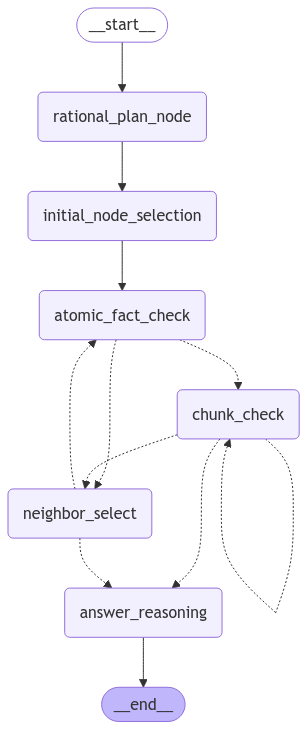

In [31]:
langgraph = StateGraph(OverallState, input=InputState, output=OutputState)
langgraph.add_node(rational_plan_node)
langgraph.add_node(initial_node_selection)
langgraph.add_node(atomic_fact_check)
langgraph.add_node(chunk_check)
langgraph.add_node(answer_reasoning)
langgraph.add_node(neighbor_select)

langgraph.add_edge(START, "rational_plan_node")
langgraph.add_edge("rational_plan_node", "initial_node_selection")
langgraph.add_edge("initial_node_selection", "atomic_fact_check")
langgraph.add_conditional_edges(
    "atomic_fact_check",
    atomic_fact_condition,
)
langgraph.add_conditional_edges(
    "chunk_check",
    chunk_condition,
)
langgraph.add_conditional_edges(
    "neighbor_select",
    neighbor_condition,
)
langgraph.add_edge("answer_reasoning", END)

langgraph = langgraph.compile()

# View
display(Image(langgraph.get_graph().draw_mermaid_png()))

We begin by defining the state graph object, where we can define the information passed along in the LangGraph. Each node is simply added with the add_node method. Normal edges, where one step always follows the other, can be added with a add_edge method. On the other hand, if the traversals is dependent on previous actions, we can use the add_conditional_edge and pass in the function that selects the next node.

## Evaluation

In [39]:
langgraph.invoke({"question":"What is Patient name?"})

--------------------
Step: rational_plan
Rational plan: To answer the question regarding the patient's name, I would need to locate specific sections or details in the provided article where the patient's identity is mentioned. This could include looking for direct mentions of the patient's name or any identifiers related to the patient.
--------------------
Step: atomic_fact_check
Reading atomic facts about: ['Patient Name', 'Sarita Sharma', 'SARITA SHARMA', 'SELFSARITA SHARMA', 'NAME']
Rational for next action after atomic check: Since the atomic facts consistently mention the patient's name as Sarita Sharma, further reading of chunks is unnecessary for answering the question about the patient's name.
Chosen action: {'function_name': 'stop_and_read_neighbor', 'arguments': []}
Key elements: ['Patient Name', 'Sarita Sharma', 'SARITA SHARMA', 'SELFSARITA SHARMA', 'NAME']
--------------------
Step: neighbor select
Possible candidates: [{'possible_candidates': ['43Y/F', '43 years', 'Aarog

{'answer': "The patient's name is Sarita Sharma.",
 'analysis': "The notebook clearly states that the patient's name is Sarita Sharma.",
 'previous_actions': ['rational_plan',
  'initial_node_selection',
  "atomic_fact_check(['Patient Name', 'Sarita Sharma', 'SARITA SHARMA', 'SELFSARITA SHARMA', 'NAME'])",
  'neighbor_select()',
  'answer_reasoning']}

In [41]:
langgraph.invoke({"question":"Is there any anomaly in her report?"})

--------------------
Step: rational_plan
Rational plan: To determine if there is any anomaly in her report, the first step is to understand what the report is about and what constitutes a normal or expected outcome for such a report. Next, we need to review the specific details, data, or findings presented in the report to identify any deviations from these expected outcomes or standards. Finally, comparing these findings against established norms or benchmarks will help in identifying any anomalies.
--------------------
Step: atomic_fact_check
Reading atomic facts about: ['neurological abnormalities', 'findings', 'Clinical Significance', 'clinical examination', 'Report Released']
Rational for next action after atomic check: To further understand the specifics of the report and to identify any anomalies, it is necessary to review the text chunks that discuss the details of the report and how the results are assessed.
Chosen action: {'function_name': 'read_chunk', 'arguments': [['9e9eae

{'answer': 'No, there is no indication of any anomaly in her report based on the provided notebook content.',
 'analysis': 'The notebook content describes a medical diagnostic report that includes various health assessments and details about sample handling and test results. It lists specific tests such as alkaline phosphatase, bilirubin, GGT, SGOT, SGPT, and total protein, along with their normal ranges. However, the notebook does not explicitly mention any anomalies or irregularities in the report itself or in the test results.',
 'previous_actions': ['rational_plan',
  'initial_node_selection',
  "atomic_fact_check(['neurological abnormalities', 'findings', 'Clinical Significance', 'clinical examination', 'Report Released'])",
  'read_chunks(5cec82bb1ec76578f3e9cd01e911b45d)',
  'answer_reasoning']}

In [43]:
langgraph.invoke({"question":"Any specific problem identified in the report?"})

--------------------
Step: rational_plan
Rational plan: To answer this question, I will need to identify and summarize any specific problems that were highlighted in the report. This involves looking for sections in the report that discuss challenges, issues, or concerns related to the subject of the report.
--------------------
Step: atomic_fact_check
Reading atomic facts about: ['Unsatisfactory Control', 'Poor Control', 'Persistently unexplained', 'Structural Implication', 'Severe Decrease']
Rational for next action after atomic check: To further understand the context and details of these problems, it would be beneficial to read the text chunks associated with these atomic facts.
Chosen action: {'function_name': 'read_chunk', 'arguments': [['a748cced28bfb66bb9ab29dcbea9d475', 'f9cc00af5be10029c852443a01b0c765', 'da7a4f0fd3310960fac72b4a2d013330', 'd7e6a505b13aba53df4154095ca40a20']]}
--------------------
Step: read chunk(d7e6a505b13aba53df4154095ca40a20)
Rational for next action aft

{'answer': 'Yes, the report identifies specific problems related to diabetes control, hsCRP testing, and kidney function estimation.',
 'analysis': 'The notebook content reveals several specific problems identified in the report: 1. Diabetes control issues, particularly related to the levels of HbA1c and blood glucose. 2. Problems with hsCRP testing, which requires further evaluation for non-cardiovascular causes if results are persistently unexplained and marked. 3. Issues related to kidney function, specifically mentioned are the eGFR levels indicating different stages of kidney function and the importance of using the CKD-EPI Creatinine Equation for estimating eGFR in the management of chronic kidney disease.',
 'previous_actions': ['rational_plan',
  'initial_node_selection',
  "atomic_fact_check(['Unsatisfactory Control', 'Poor Control', 'Persistently unexplained', 'Structural Implication', 'Severe Decrease'])",
  'read_chunks(d7e6a505b13aba53df4154095ca40a20)',
  'answer_reasonin

# 